In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Initial EDA

Let's load the dataset and explore some examples of jokes

In [2]:
pd.set_option('max_colwidth', 200)

df = pd.read_csv('shortjokes.csv', index_col=0, dtype=str)
df.tail(3)

,Joke
ID,
231655,What did the RAM stick say to the politician? I'm PC2!
231656,what do you call a play about victorian era menstruation? A period piece!
231657,Calculus should be taught in every high school around the world. It is such an integral field of math.


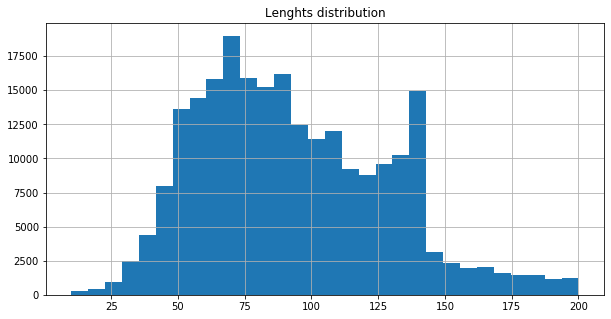

In [3]:
df['length'] = df.Joke.map(len)
plt.title('Lenghts distribution')
df.length.hist(figsize=(10, 5), bins=30)
plt.show()

In [4]:
maxlen = df.length.max()
maxlen

200

There is a classic setup-punchline joke structure. Let's try to hind how common it is in our data.


In [5]:
print(df.Joke.iloc[6], df.Joke.iloc[119], df.Joke.iloc[1123], df.Joke.iloc[10001], sep='\n')

Why was the musician arrested? He got in treble.
Why do you call a Mexican midget a paragraph? ...because he's too short to be called an essay.
I just met someone who was a steam-roller operator. He was such a flatterer.
Someone tried to sell me a coffin today... I told them its the last thing I need.


In [6]:
len(df.Joke[df.Joke.str.contains('[\?]+', )])
df['contains_?'] = df.Joke.str.contains('[\?]+', )

In [7]:
df.Joke[df.Joke.str.contains('[\?]+', )][20:25]

ID
37                                                                  Which gospel contains Jesus' parable about the shades of numbers? Math hue.
41                                                                        What's Al-Qaeda's favorite American football team? The New York jets.
42    INTERVIEWER: Why do you want to work here? ME: *crumbs tumbling from my mouth* Oh, I don't. I was just walking by and saw you had donuts.
44                                                 Did you hear about the midget psychic who escaped from prison? He's a small medium at large.
46                                    What's the difference between a car tyre, and 365 condoms? One's a Goodyear, an the other's a great year.
Name: Joke, dtype: object

In [8]:
df.Joke[df.Joke.str.contains('[\?]+', )].map(lambda x: x.lower().split(' ')[0]).value_counts()

what          29981
why           15909
how            9933
what's         9091
did            3779
              ...  
eggs              1
please.           1
leo               1
universe's        1
astronomy         1
Name: Joke, Length: 5565, dtype: int64

In [9]:
df.Joke[df.Joke.str.contains('[\?]+', )].map(lambda x: tuple(x.lower().split(' ')[:2])).value_counts()[:10]

(what, do)       13313
(what's, the)     5805
(what, did)       5158
(why, did)        4584
(how, do)         3955
(what, is)        3749
(did, you)        3635
(why, do)         2584
(how, many)       2491
(what, does)      2233
Name: Joke, dtype: int64

As it seems, half of the jokes in the dataset are presented as setup-punchline in a form of question-answer. But not so straightforward jokes are presented aswell.

In [10]:
print(df.Joke.iloc[15], df.Joke.iloc[25], df.Joke.iloc[38], sep='\n')

You ever notice that the most dangerous thing about marijuana is getting caught with it?
How to get a cop's attention
Ted Cruz getting elected.


# LSTM-based generation

## Char-based generation

Tokenizing:

In [13]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
df['tokenized'] = df.Joke.map(tk.tokenize)

In [14]:
BOS, EOS = ' ', '\n'

lines = df.Joke.apply(lambda line: BOS + line.replace(EOS, ' ') + EOS).tolist()

In [15]:
from tqdm import tqdm_notebook

d = {}
tokens = []

for line in tqdm_notebook(lines):
    for token in list(line):
        if token not in d: 
            d[token] = 1
            tokens.append(token)
        else: d[token] += 1

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert BOS in tokens, EOS in tokens

/Users/litleo/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



n_tokens =  98


In [16]:
token_to_id = {}
for ind, elem in enumerate(tokens):
    token_to_id[elem] = ind

In [17]:

list(token_to_id.items())[:5]

[('\x08', 0), ('\n', 1), ('\x10', 2), (' ', 3), ('!', 4)]

Forming a matrix:

In [18]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [19]:
dummy_lines = [
    ' A cow walks into a bar...\n',
    ' What do you call a pirat on a plain?\n'
]
print(to_matrix(dummy_lines))

[[ 3 36  3 70 82 90  3 90 68 79 78 86  3 76 81 87 82  3 68  3 69 68 85 17
  17 17  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 3 58 75 68 87  3 71 82  3 92 82 88  3 70 68 79 79  3 68  3 83 76 85 68
  87  3 82 81  3 68  3 83 79 68 76 81 34  1]]


Firstly let's try to generate jokes using character level information:

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=512, gpu = -1):
        super(RNNLanguageModel, self).__init__()
        """ 
        Build a recurrent language model.
        """
        self.gpu = gpu
        self.emb = nn.Embedding(n_tokens, emb_size)        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hid_size, bidirectional = False, batch_first = True) 
        self.dense = nn.Linear(hid_size, n_tokens)        
        self.next_token_probs = nn.Softmax(dim=2)

        
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        
        emb_ix = self.emb(input_ix)       
        output, hidden = self.lstm(emb_ix)     
        logits_ix = self.dense(output)
        return logits_ix

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_tensor = torch.from_numpy(to_matrix([prefix])).to(torch.int64)
        prefix_tensor = to_gpu(prefix_tensor, self.gpu)        
        probs = self.next_token_probs (self(prefix_tensor)).cpu().detach().numpy()
        print(probs.shape)
        print(probs[0])    
        probs = probs[0][len(prefix) - 1]
        del prefix_tensor
        return dict(zip(tokens, list(probs)))

In [22]:
def to_gpu(tensor, gpu):   
    if gpu > -1:
        return tensor.cuda(device=gpu)
    else:
        return tensor.cpu()

In [23]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    a = input_ix.eq(eos_ix)
    count_eos = torch.cumsum(a, 1)
    lengths = torch.sum(count_eos.eq(0), 1)
    return lengths + 1 

In [24]:
def sequence_mask(lengths, maxlen, dtype=torch.bool):
    """
    :param lenghts: array of size K, lenghts of input K lines
    :param maxlen: number of steps in our case
    """
    if maxlen is None:
        maxlen = lengths.max()
    cuda_check = lengths.is_cuda
    if cuda_check:
        cuda_device = lengths.get_device()
    
    one_tensor = torch.ones((len(lengths), maxlen))
    if (cuda_check):
        one_tensor = one_tensor.cuda(device=cuda_device)
    
    mask = ~(one_tensor.cumsum(dim=1).t() > lengths).t()
    mask.type(dtype)
    return mask

In [25]:
def compute_loss(logits, targets):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :return: scalar
    """
    lengths = compute_lengths(targets)
    logits = logits.permute(0, 2, 1)
    m = nn.LogSoftmax(dim=1)


    seq_m = sequence_mask(lengths=lengths, maxlen=m(logits).size()[2])
    
    criterion = nn.CrossEntropyLoss(reduction='none')

    loss = criterion(m(logits), targets) 
    loss = seq_m * loss
    
    loss = torch.sum(loss, dim = 1)
  
    return torch.mean(loss)

In [26]:
def score_lines(dev_lines, batch_size, model):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        
        tg = to_gpu(torch.from_numpy(batch_ix[:, 1:]).to(torch.int64), model.gpu)
        
        input_ = to_gpu(torch.from_numpy(batch_ix[:, :-1]).to(torch.int64), model.gpu).to(torch.int64)
        
        loss_i = compute_loss(model(input_), tg)
        dev_loss_num += loss_i.cpu().detach().numpy() * len(batch_ix)
        dev_loss_len += len(batch_ix)
        del tg, input_, loss_i
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=320):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [28]:
rnn_lm1 = RNNLanguageModel(gpu = 0)
rnn_lm1.cuda(device = rnn_lm1.gpu)


In [29]:
from IPython.display import clear_output
from random import sample
from tqdm import trange, tnrange, tqdm_notebook

In [30]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.2, 
                                          random_state=42)

In [31]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [32]:
optimizer = torch.optim.Adam(rnn_lm1.parameters(), lr=0.003)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

# dev_history.append((0, score_lines(dev_lines, batch_size, rnn_lm1)))

for i in tqdm_notebook(range(len(train_history), 15000)):
    batch = to_matrix(sample(train_lines, batch_size))  
    real_answer = to_gpu(torch.from_numpy(batch[:, 1:]).to(torch.int64), rnn_lm1.gpu)
    input_seq = to_gpu(torch.from_numpy(batch[:, :-1]).to(torch.int64), rnn_lm1.gpu).to(torch.int64)
    optimizer.zero_grad()
    logits = rnn_lm1(input_seq)
    loss_i = compute_loss(logits, real_answer)
    train_history.append((i, loss_i.detach().cpu().numpy()))
    
    loss_i.backward()
    optimizer.step()
    
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        print (loss_i)
        for j in range(3):
            print(generate(rnn_lm1, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size, rnn_lm1)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
    del logits, input_seq, loss_i

/Users/litleo/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


AssertionError: Torch not compiled with CUDA enabled



```
# This is formatted as code
```

Now let's explore, what we can generate so far

In [ ]:
for i in range(5):
    print(generate(rnn_lm1, temperature=0.25).strip())

What do you call a back and the man and the bately the really can and the presidents the problem and the store the man and the people and the be the bar and the contind the car the party wife the be the man the car the seat the see the car and an are he can the be a bar and the country the bate the think I can and the
I think I want the back the more the bar in the bring the countries and the baby it was a bar to she was the be and the best back the see the bartender with a back the first first more and the people the be and the baby and the car the people the difference between a little conters is the person the other the man the m
What do you call a say to the start the like and a birth the car and the think it was a start and the bar and it was like the bank and the player that it was a bar and the first really can says "What was a bar and the people the be the people and a bar the party should have a people and the both and the man what do you
What do you call a bar be see the comp

In [ ]:
for i in range(5):
    print(generate(rnn_lm1, temperature=0.5).strip())

I was like the Unically do a burn the difference between a bar and the proper so an it in a black cook full of his beer and who has a black in the baby car to the man his other and who was in the start of the milyou me lettiout a woman dickle the le it to change the wife. I could know it.
Why do you like the bahs the worse and of the man and he was the room the fuck in the people and hat if you guy is a busue and a before the onic be the people carted Halling of a race the restrice and the black with the be her one to have to chanted like they says it say and a bar to change the fight have being a littl
What do you call a car to get a really can't people what is my gun walking out of the door. They should
What do you call a said the favorite that facts that say it is car is a do the more that it and the doctor is at the black her in the words the time for a good and the sound the counting and the difference this on it.
How do you can and the peet is all the hard and the before you be a

In [ ]:
for i in range(5):
    print(generate(rnn_lm1, temperature=0.75).strip())

How do you bans in the man are the flame to like a To windowber on a replied to she was are of the greetle was the really could have I sition the need from their take a From Mob tha can hate.
Doctor that was in the piece your something only through a life being He can this man after that uncyclives the pants.
Did you hear appear next that and the big chicken is the Do cook. Any porns and have broke she was so parmplayer that are he traft country, and the put up that poor beer at him has the difference between mother with Trump with a back of the Evidend working out the Bir and the cupian drop "After.
Why did the OJ are firit much forgot mister about a people and a leved? This.
How do an the Would be gat I'd out of the common is a blound a childrented and them have to the wora? He was accidentise says "Who was turn in him counts and to get it that this bamp hards.


Seems that with low temperature net stucks on "What do you call" and "I was going to" structures. Other hand-picked emaples are presented bellow

In [ ]:
t25_examples = [
' What do you call a woman with two black people? A prostitute.',
' What do you call a black man with a dick? A snake they were too long.',
" What do you call a black man who has a straight walk on a bike? A student says \"I don't know.\" \"Why?\" \"I don't know, I'm sorry but I didn't know it's the one with the sign on the side!\"",
' What do you call a man with no arms? A pilot.',
' What do you call a fat girl? A pilot.',
' What do you call a police officer that likes to take a straight condition? A pilot.'
]

t50_examples = [
' What do you call a man with a tree? A homeless parent!',
' What did the sandwich say to the piano? The waiter is the best police suspect.',
' Why did the chicken cross the road? To get to the other side!',
' When is it called the bees? A horse',
' Why do most people have sex with his brother? Because it\'s been dead.',
' What do you call a cow with no legs? Deprecating your resumes.'
]

t75_examples = [
' Me: What\'s your favourite movie?" "What are you doing?" "Where\'s the house?"',
' A horse walks into a bar and the other one day caught for you.',
' What\'s the difference between a baby and a drama? Starbucks hand stones',
' Why did the two monster kicked back so good at the Pope? Because it was delicious here, one of the fortunes.',
' Knock Knock! Who\'s there? Kevin Bun Hoover.',
' Customer: Why do you meant to the fact that I have a bad athletic? The popcorn!'
]

## Word-based generation

As char-based jokes appeared to be not that funny, let's try word-level now!



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from random import sample
from tqdm import tqdm, trange, tnrange, tqdm_notebook
import sys

In [ ]:
vocab = set()
texts = []
for words in tqdm_notebook(df.tokenized):
        vocab.update(words)
        texts.append(words)
len(vocab)

75139

In [ ]:
def to_matrix(lines, vocab, max_len=None, dtype='int32'):
    if isinstance(lines, str):
         lines = lines.split(' ')

    """Casts a list of lines into a matrix"""
    pad = vocab['EOS']
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = [vocab.get(l, vocab['UNK']) for l in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
    lines_ix = torch.LongTensor(lines_ix)
    return lines_ix

### GLoVe embeddings

For this model we will use pretrained GloVe embeddings.

In [ ]:
# load the embeddings
def load_embeddings(emb_path, vocab):
    clf_embeddings = {}
    emb_vocab = set()
    for line in open(emb_path):
        line = line.strip('\n').split()
        word, emb = line[0], line[1:]
        emb = [float(e) for e in emb]
        if word in vocab:
            clf_embeddings[word] = emb
    for w in vocab:
        if w in clf_embeddings:
            emb_vocab.add(w)
    word2idx = {w: idx for (idx, w) in enumerate(emb_vocab)}
    max_val = max(word2idx.values())
    
    word2idx['EOS'] = max_val + 1
    word2idx['SOS'] = max_val + 2
    word2idx['UNK'] = max_val + 3
    
    emb_dim = len(list(clf_embeddings.values())[0])
    clf_embeddings['UNK'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['EOS'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['SOS'] = [0.0 for i in range(emb_dim)]
    embeddings = [[] for i in range(len(word2idx))]
    for w in word2idx:
        embeddings[word2idx[w]] = clf_embeddings[w]
    embeddings = torch.Tensor(embeddings)
    return embeddings, word2idx
embeddings, vocab = load_embeddings('glove.6B.300d.txt', vocab)

In [ ]:
tokens = list(vocab.keys())

In [ ]:
class EMBW_LSTM(nn.Module):
    def __init__(self, n_tokens=len(vocab), hid_size=512, gpu = -1):
        super(EMBW_LSTM, self).__init__()
        """ 
        Build a recurrent language model.
        """
        self.gpu = gpu
        self.embedding = nn.Embedding.from_pretrained(embeddings)
        self.embedding.weight.requires_grad = False       
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim, hidden_size=hid_size,
                            bidirectional=False, batch_first=True) 
        self.dense = nn.Linear(hid_size, n_tokens)        
        self.next_token_probs = nn.Softmax(dim=2)

        
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        
        emb_ix = self.embedding(input_ix)       
        output, hidden = self.lstm(emb_ix)     
        logits_ix = self.dense(output)
        return logits_ix

    def get_possible_next_tokens(self, prefix=['SOS'], temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_tensor = (to_matrix([prefix], vocab)).to(torch.int64)
        prefix_tensor = to_gpu(prefix_tensor, self.gpu)        
        probs = self.next_token_probs(self(prefix_tensor)).cpu().detach().numpy()  
        # print(probs.shape)
        # print(probs)  
        probs = probs[0][len(prefix) - 1]
        del prefix_tensor
        return dict(zip(tokens, list(probs)))

In [ ]:
def to_gpu(tensor, gpu):   
    if gpu > -1:
        return tensor.cuda(device=gpu)
    else:
        return tensor.cpu()

In [ ]:
def compute_lengths(input_ix, eos_ix=vocab['EOS']):
    a = input_ix.eq(eos_ix)
    count_eos = torch.cumsum(a, 1)
    lengths = torch.sum(count_eos.eq(0), 1)
    return lengths + 1 

In [ ]:
def sequence_mask(lengths, maxlen, dtype=torch.bool):
    """
    :param lenghts: array of size K, lenghts of input K lines
    :param maxlen: number of steps in our case
    """
    if maxlen is None:
        maxlen = lengths.max()
    cuda_check = lengths.is_cuda
    if cuda_check:
        cuda_device = lengths.get_device()
    
    one_tensor = torch.ones((len(lengths), maxlen))
    if (cuda_check):
        one_tensor = one_tensor.cuda(device=cuda_device)
    
    mask = ~(one_tensor.cumsum(dim=1).t() > lengths).t()
    mask.type(dtype)
    return mask

In [ ]:
def compute_loss(logits, targets):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :return: scalar
    """
    lengths = compute_lengths(targets)
    logits = logits.permute(0, 2, 1)
    m = nn.LogSoftmax(dim=1)


    seq_m = sequence_mask(lengths=lengths, maxlen=m(logits).size()[2])
    
    criterion = nn.CrossEntropyLoss(reduction='none')

    loss = criterion(m(logits), targets) 
    loss = seq_m * loss
    
    loss = torch.sum(loss, dim = 1)
  
    return torch.mean(loss)

In [ ]:
def score_lines(dev_lines, batch_size, model):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size], vocab)
        
        tg = to_gpu((batch_ix[:, 1:]).to(torch.int64), model.gpu)
        
        input_ = to_gpu((batch_ix[:, :-1]).to(torch.int64), model.gpu).to(torch.int64)
        
        loss_i = compute_loss(model(input_), tg)
        dev_loss_num += loss_i.cpu().detach().numpy() * len(batch_ix)
        dev_loss_len += len(batch_ix)
        del tg, input_, loss_i
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=['SOS'], temperature=1.0, max_len=180):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    prefix=['SOS']
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())

        # cut the 'UNK' token to not be generated
        tokens = tokens[:-1]
        probs = probs[:-1]

        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        
        prefix += [next_token]
        # print(prefix)
        # print(next_token == 'EOS')
        if next_token == 'EOS':
            return ' '.join(prefix[1:-1])
        if len(' '.join(prefix[1:])) > max_len:
            prefix += ['EOS']
            return ' '.join(prefix[1:-1])

In [ ]:
!nvidia-smi

Tue Dec 17 00:15:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   2619MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
ew_lstm = EMBW_LSTM(gpu = 0)
ew_lstm.cuda(device = ew_lstm.gpu)


In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(texts, test_size=0.1, 
                                          random_state=42)

Iteration 15000


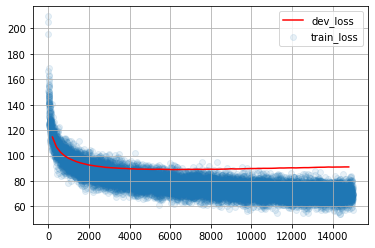

Generated examples (tau=0.5):
tensor(74.1019, device='cuda:0', grad_fn=<MeanBackward0>)
a dog that steals my nails ? a woman .
the difference between a chickpea and a garbanzo bean ? i can tuna piano a tuna
the difference between a boy scout and a jew ? the boy scout comes back from camp .
Scoring dev...
#14999 Dev loss: 91.319
Saving model at ewords_lstm15000.pt ...



In [ ]:
optimizer = torch.optim.Adam(ew_lstm.parameters(), lr=0.003)

batch_size = 64
score_dev_every = 200
save_model_every = 3000
train_history, dev_history = [], []

# dev_history.append((0, score_lines(dev_lines, batch_size, ew_lstm)))

for i in tqdm_notebook(range(len(train_history), 15000), file=sys.stdout):
    batch = to_matrix(sample(train_lines, batch_size), vocab)  
    real_answer = to_gpu((batch[:, 1:]).to(torch.int64), ew_lstm.gpu)
    input_seq = to_gpu((batch[:, :-1]).to(torch.int64), ew_lstm.gpu).to(torch.int64)
    optimizer.zero_grad()
    logits = ew_lstm(input_seq)
    loss_i = compute_loss(logits, real_answer)
    train_history.append((i, loss_i.detach().cpu().numpy()))
    
    loss_i.backward()
    optimizer.step()
    
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        print('Iteration', i+1)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        print (loss_i)
        for j in range(3):
            print(generate(ew_lstm, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size, ew_lstm)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
    del logits, input_seq, loss_i

    if (i + 1) % save_model_every == 0:
        print('Saving model at', 'ewords_lstm' + str(i+1) + '.pt', '...')
        torch.save(ew_lstm.state_dict(), 'ewords_lstm' + str(i+1) + '.pt')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
t50_examples = [
'the difference between a black person and a gun of strippers ? one has a gun , and the other is a gun .',
'the difference between a black man and a gun ? a gun only has one trigger .'

]

In [ ]:
for i in range(10):
    print(generate(ew_lstm, temperature=0.9))

the difference between an arts student and an american football player ? the latter of the session is going full of letters .
the difference between a porsche and a trashcan full of pygmies ? " at least you can buy a spot all the last cruise control "
" gullible " o " so i got all this game . " below average so he caught me from birth , we donate blood families to death die on our lives ? no .
the difference between an oral thermometer and a rectal thermometer ? one has a moustache .
the difference between jam and barry ? one of my garage is about legos .
started looking changed this morning with the windows 7 .
the difference between a lentil and a chickpea ? to feed a lentil on a pound of swiss pizza
white : doctor , here question ? me : i have a son of black people .
decided a new not to have local camera anymore ... especially if you have time it for something that suggests you , sir .
no law right now the last time you realise that you wondering if your wife gives you a seat


In [ ]:
sdf['tokenized']

### Glove + trained embeddings

As there are a lot of special words presented, which are somethimes not presented in glove, we decided to try to concatenate glove embeddings layer to a trainable embeddings layer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from random import sample
from tqdm import tqdm, trange, tnrange, tqdm_notebook
import sys

In [ ]:
vocab = set()
texts = []
for words in tqdm_notebook(df.tokenized):
        vocab.update(words)
        texts.append(words)

In [ ]:
from collections import Counter
from itertools import chain

c = Counter(chain.from_iterable(df.tokenized.to_numpy()))
filtered_vocab = [key for key, val in c.items() if val > 1]

In [ ]:
len(filtered_vocab)

37611

In [ ]:
# load the embeddings
def load_embeddings_all_words(emb_path, vocab, filtered_vocab):
    clf_embeddings = {}
    emb_vocab = set()
    for line in tqdm_notebook(open(emb_path)):
        line = line.strip('\n').split()
        word, emb = line[0], line[1:]
        emb = [float(e) for e in emb]
        if word in vocab:
            clf_embeddings[word] = emb
    
    emb_vocab = set()
    for w in vocab:
        if w in clf_embeddings:
            emb_vocab.add(w)
        elif w in filtered_vocab:
            emb_vocab.add(w)
            clf_embeddings[w] = np.zeros(300)
    word2idx = {w: idx for (idx, w) in enumerate(emb_vocab)}
    max_val = max(word2idx.values())
    
    word2idx['EOS'] = max_val + 1
    word2idx['SOS'] = max_val + 2
    word2idx['UNK'] = max_val + 3
    
    emb_dim = len(list(clf_embeddings.values())[0])
    clf_embeddings['UNK'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['EOS'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['SOS'] = [0.0 for i in range(emb_dim)]
    embeddings = [[] for i in range(len(word2idx))]
    for w in word2idx:
        embeddings[word2idx[w]] = clf_embeddings[w]
    embeddings = torch.Tensor(embeddings)
    return embeddings, word2idx
embeddings, vocab = load_embeddings_all_words('glove.6B.300d.txt', vocab, set(filtered_vocab))

In [ ]:
tokens = list(vocab.keys())

In [ ]:
len(tokens)

52074

In [ ]:
class WG_LSTM(nn.Module):
    def __init__(self, n_tokens=len(vocab), hid_size=1024, gpu = -1):
        super(WG_LSTM, self).__init__()
        """ 
        Build a recurrent language model.
        """
        self.gpu = gpu
        self.glove_embedding = nn.Embedding.from_pretrained(embeddings)
        self.glove_embedding.weight.requires_grad = False
        self.embedding = nn.Embedding(n_tokens, 500)

        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim + self.glove_embedding.embedding_dim,
                            hidden_size=hid_size,
                            bidirectional=False, batch_first=True)
        
        self.dense_1 = nn.Linear(hid_size, 10000)
        self.dense_2 = nn.Linear(10000, n_tokens)
        self.next_token_probs = nn.Softmax(dim=2)

        
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        
        trained_emb_ix = self.embedding(input_ix)
        glove_ix = self.glove_embedding(input_ix)

        emb_ix = torch.cat([trained_emb_ix, glove_ix], axis=2)

        output, hidden = self.lstm(emb_ix)
        output = self.dense_1(output)
        logits_ix = self.dense_2(output)
        return logits_ix

    def get_possible_next_tokens(self, prefix=['SOS'], temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_tensor = (to_matrix([prefix], vocab)).to(torch.int64)
        prefix_tensor = to_gpu(prefix_tensor, self.gpu)        
        probs = self.next_token_probs(self(prefix_tensor)).cpu().detach().numpy()  
        # print(probs.shape)
        # print(probs)  
        probs = probs[0][len(prefix) - 1]
        del prefix_tensor
        return dict(zip(tokens, list(probs)))

In [ ]:
wg_lstm = WG_LSTM(gpu = 0)
wg_lstm.cuda(device = wg_lstm.gpu)

WG_LSTM(
  (glove_embedding): Embedding(52074, 300)
  (embedding): Embedding(52074, 500)
  (lstm): LSTM(800, 1024, batch_first=True)
  (dense_1): Linear(in_features=1024, out_features=10000, bias=True)
  (dense_2): Linear(in_features=10000, out_features=52074, bias=True)
  (next_token_probs): Softmax(dim=2)
)

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(texts, test_size=0.1, 
                                          random_state=42)

In [ ]:
wg_lstm.parameters

<bound method Module.parameters of WG_LSTM(
  (glove_embedding): Embedding(52074, 300)
  (embedding): Embedding(52074, 500)
  (lstm): LSTM(800, 1024, batch_first=True)
  (dense_1): Linear(in_features=1024, out_features=10000, bias=True)
  (dense_2): Linear(in_features=10000, out_features=52074, bias=True)
  (next_token_probs): Softmax(dim=2)
)>

Iteration 3400


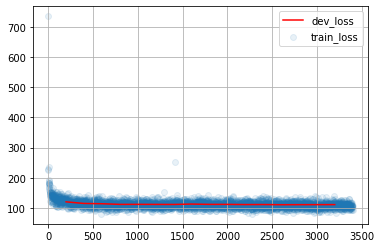

Generated examples (tau=0.5):
tensor(106.3923, device='cuda:0', grad_fn=<MeanBackward0>)
involves a blonde .
letters : do you like a nice is the only other ? a : * * * * *
letters a mexican who will be like a mexican and a lot of your penis .
Scoring dev...
#3399 Dev loss: 110.308


In [ ]:
optimizer = torch.optim.Adam(wg_lstm.parameters(), lr=0.003)

batch_size = 30
score_dev_every = 200
save_model_every = 3000
train_history, dev_history = [], []

# dev_history.append((0, score_lines(dev_lines, batch_size, wg_lstm)))

for i in tqdm_notebook(range(len(train_history), 15000), file=sys.stdout):
    batch = to_matrix(sample(train_lines, batch_size), vocab)  
    real_answer = to_gpu((batch[:, 1:]).to(torch.int64), wg_lstm.gpu)
    input_seq = to_gpu((batch[:, :-1]).to(torch.int64), wg_lstm.gpu).to(torch.int64)
    optimizer.zero_grad()
    logits = wg_lstm(input_seq)
    loss_i = compute_loss(logits, real_answer)
    train_history.append((i, loss_i.detach().cpu().numpy()))
    
    loss_i.backward()
    optimizer.step()
    
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        print('Iteration', i+1)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        print (loss_i)
        for j in range(3):
            print(generate(wg_lstm, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size, wg_lstm)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
    del logits, input_seq, loss_i

    if (i + 1) % save_model_every == 0:
        print('Saving model at', 'ewordsembeds_lstm' + str(i+1) + '.pt', '...')
        torch.save(wg_lstm.state_dict(), 'ewordsembeds_lstm' + str(i+1) + '.pt')

# ElMo-embedings

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from random import sample
from tqdm import tqdm, trange, tnrange, tqdm_notebook
import sys

In [ ]:
from allennlp.data.token_indexers.elmo_indexer import ELMoTokenCharactersIndexer
from allennlp.commands.elmo import ElmoEmbedder
from allennlp.modules.elmo import Elmo, batch_to_ids
from allennlp.modules.elmo import Elmo, batch_to_ids

In [ ]:
setup_punchlines = df[df['contains_?'] == True]['Joke']

In [ ]:
def first_questionmark(str_):
  return str_.find('?')

In [ ]:
from sklearn.model_selection import train_test_split

train_setup_punchlines, dev_setup_punchlines = train_test_split(setup_punchlines, test_size=0.1, 
                                                                random_state=42)

In [ ]:
train_setup_punchlines = pd.DataFrame(train_setup_punchlines)

In [ ]:
train_setup_punchlines['S'] = train_setup_punchlines['Joke'].map(lambda joke: joke[:first_questionmark(joke) + 1])

In [ ]:
train_setup_punchlines['P'] = train_setup_punchlines['Joke'].map(lambda joke: joke[first_questionmark(joke) + 2:])

In [ ]:
train_setup_punchlines = train_setup_punchlines.drop(columns=['Joke'])

In [ ]:
dev_setup_punchlines = pd.DataFrame(dev_setup_punchlines)

In [ ]:
dev_setup_punchlines['S'] = dev_setup_punchlines['Joke'].map(lambda joke: joke[:first_questionmark(joke) + 1])
dev_setup_punchlines['P'] = dev_setup_punchlines['Joke'].map(lambda joke: joke[first_questionmark(joke) + 2:])

In [ ]:
dev_setup_punchlines = dev_setup_punchlines.drop(columns=['Joke'])

In [ ]:
train_setup_punchlines.to_csv('setup_punchline_train.csv', header=None, index=None, sep='\t')

In [ ]:
dev_setup_punchlines.to_csv('setup_punchline_dev.csv', header=None, index=None, sep='\t')

Prepare data: leave only question -> punchline

In [ ]:
from allennlp.data.dataset_readers.seq2seq import Seq2SeqDatasetReader
from allennlp.data.tokenizers.word_tokenizer import WordTokenizer
from allennlp.data.tokenizers.character_tokenizer import CharacterTokenizer
from allennlp.data.token_indexers.single_id_token_indexer import SingleIdTokenIndexer
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper
from allennlp.data.vocabulary import Vocabulary

In [ ]:
reader = Seq2SeqDatasetReader(
    source_tokenizer=CharacterTokenizer(),
    target_tokenizer=CharacterTokenizer())

In [ ]:
train_data = reader.read('setup_punchline_train.csv')
val_data = reader.read('setup_punchline_dev.csv')

55764it [00:08, 11435.83it/s]

KeyboardInterrupt: ignored

In [ ]:
vocab = Vocabulary.from_instances(train_data + val_data)

In [ ]:
vocab.save_to_files("/elmochar/vocabulary")

Model options:

In [ ]:
import torch
import torch.optim as optim
from allennlp.data.dataset_readers.seq2seq import Seq2SeqDatasetReader
from allennlp.data.iterators import BucketIterator
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data.tokenizers.character_tokenizer import CharacterTokenizer
from allennlp.data.tokenizers.word_tokenizer import WordTokenizer
from allennlp.data.vocabulary import Vocabulary
from allennlp.nn.activations import Activation
from allennlp.models.encoder_decoders.simple_seq2seq import SimpleSeq2Seq
from allennlp.models.encoder_decoders.composed_seq2seq import ComposedSeq2Seq
from allennlp.modules.attention import LinearAttention, BilinearAttention, DotProductAttention
from allennlp.modules.seq2seq_encoders import PytorchSeq2SeqWrapper, StackedSelfAttentionEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.predictors import SimpleSeq2SeqPredictor, Seq2SeqPredictor
from allennlp.training.trainer import Trainer
import itertools

In [ ]:
Q_EMBEDDING_DIM = 256
HIDDEN_DIM = 256
A_EMBEDDING_DIM = 256
CUDA_DEVICE = 0
metrics_history = []

In [ ]:
q_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                        embedding_dim=Q_EMBEDDING_DIM)

encoder = StackedSelfAttentionEncoder(input_dim=Q_EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, projection_dim=128, feedforward_hidden_dim=128, num_layers=1, num_attention_heads=8)

source_embedder = BasicTextFieldEmbedder({"tokens": q_embedding})

attention = DotProductAttention()

model = SimpleSeq2Seq(vocab, source_embedder, encoder, 200,
                      target_embedding_dim=A_EMBEDDING_DIM,
                      attention=attention, use_bleu=False)
optimizer = optim.Adam(model.parameters())
iterator = BucketIterator(batch_size=32, sorting_keys=[("source_tokens", "num_tokens")])

iterator.index_with(vocab)

model = model.cuda(0)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_data,
                  validation_dataset=val_data,
                  num_epochs=1,
                  cuda_device=CUDA_DEVICE)

for i in range(20):
    print('\nEpoch: {}\n'.format(i))
    metrics = trainer.train()
    metrics_history.append(metrics)
    predictor = SimpleSeq2SeqPredictor(model, reader)

    with open("/tmp/model.th", 'wb') as f:
      torch.save(model.state_dict(), f)
    clear_output(True)

    for instance in itertools.islice(val_data, 10):
        print('SOURCE:', ''.join([str(x) for x in instance.fields['source_tokens'].tokens[1:-1]]))
        print('GOLD:', ''.join([str(x) for x in instance.fields['target_tokens'].tokens[1:-1]]))
        print('PRED:', ''.join([str(x) for x in predictor.predict_instance(instance)['predicted_tokens']]))

SOURCE: What's an English teacher's favourite cereal?
GOLD: Synonym Grahams
PRED: A sea-sand.
SOURCE: Me: Put on your seatbelt. 13: Do I have to?
GOLD: Me: not if you want your face shattering the windshield 13: cool Me: PUT ON YOUR SEATBELT!
PRED: 
SOURCE: What do fish call a submarine?
GOLD: Unidentified Floating Object
PRED: A stick.
SOURCE: Where do Pixar employees go for Happy Hour?
GOLD: CGI Friday's.
PRED: The seats on the show.
SOURCE: What's worse than a cardboard box?
GOLD: Paper titties
PRED: 
SOURCE: What do you call a guy stuck in the same job for 30 years?
GOLD: A four term US senator.
PRED: 
SOURCE: Why do rabbits make good mathematicians?
GOLD: Because they're constantly multiplying!
PRED: Because they can't even.
SOURCE: Judge: "Reason for divorce?
GOLD:  Me: "Reconcilable differences." Judge: "Don't you mean irreconcilable?" Me: "Ugh. You sound just like her."
PRED: 
SOURCE: Why did the zombie start ripping up sheet music?
GOLD: Because he was de-composing.
PRED: He w

In [ ]:
char_reader = reader
char_model = model
char_predictor = SimpleSeq2SeqPredictor(char_model, char_reader)
train_data_char = train_data
val_data_char = val_data

In [ ]:
reader = Seq2SeqDatasetReader(
    source_tokenizer=WordTokenizer(),
    target_tokenizer=WordTokenizer())

In [ ]:
train_data = reader.read('setup_punchline_train.csv')
val_data = reader.read('setup_punchline_dev.csv')


0it [00:00, ?it/s]
118it [00:00, 1178.72it/s]
233it [00:00, 1169.10it/s]
366it [00:00, 1212.04it/s]
499it [00:00, 1243.38it/s]
628it [00:00, 1256.38it/s]
752it [00:00, 1251.06it/s]
872it [00:00, 1233.51it/s]
1005it [00:00, 1260.06it/s]
1134it [00:00, 1267.23it/s]
1270it [00:01, 1291.52it/s]
1408it [00:01, 1315.90it/s]
1551it [00:01, 1346.70it/s]
1687it [00:01, 1349.39it/s]
1822it [00:01, 1341.02it/s]
1959it [00:01, 1348.79it/s]
2098it [00:01, 1359.23it/s]
2234it [00:01, 1334.84it/s]
2376it [00:01, 1357.85it/s]
2512it [00:01, 1354.57it/s]
2655it [00:02, 1376.24it/s]
2802it [00:02, 1401.14it/s]
2943it [00:02, 1389.72it/s]
3083it [00:02, 1390.43it/s]
3226it [00:02, 1400.39it/s]
3367it [00:02, 1363.42it/s]
3507it [00:02, 1372.88it/s]
3645it [00:02, 1356.38it/s]
3781it [00:02, 1311.90it/s]
3923it [00:02, 1341.83it/s]
4064it [00:03, 1361.30it/s]
4212it [00:03, 1392.40it/s]
4359it [00:03, 1412.71it/s]
4506it [00:03, 1427.64it/s]
4655it [00:03, 1445.09it/s]
4802it [00:03, 1452.38it/s]
4948it 

In [ ]:
vocab = Vocabulary.from_instances(train_data + val_data)


100%|██████████| 107332/107332 [00:01<00:00, 63070.88it/s]

In [ ]:
vocab.save_to_files("/elmochar/word_vocabulary_v1")

In [ ]:
Q_EMBEDDING_DIM = 256
HIDDEN_DIM = 256
A_EMBEDDING_DIM = 256
CUDA_DEVICE = 0
metrics_history = []

In [ ]:
q_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                        embedding_dim=Q_EMBEDDING_DIM)

encoder = StackedSelfAttentionEncoder(input_dim=Q_EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, projection_dim=128, feedforward_hidden_dim=128, num_layers=1, num_attention_heads=8)

source_embedder = BasicTextFieldEmbedder({"tokens": q_embedding})

attention = DotProductAttention()

model = SimpleSeq2Seq(vocab, source_embedder, encoder, 200,
                      target_embedding_dim=A_EMBEDDING_DIM,
                      attention=attention, use_bleu=False)
optimizer = optim.Adam(model.parameters())
iterator = BucketIterator(batch_size=32, sorting_keys=[("source_tokens", "num_tokens")])

iterator.index_with(vocab)

model = model.cuda(0)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_data,
                  validation_dataset=val_data,
                  num_epochs=1,
                  cuda_device=CUDA_DEVICE)

for i in range(20):
    print('\nEpoch: {}\n'.format(i))
    metrics = trainer.train()
    metrics_history.append(metrics)
    predictor = SimpleSeq2SeqPredictor(model, reader)

    with open("elmo_model_word_v1.th", 'wb') as f:
      torch.save(model.state_dict(), f)
    clear_output(True)

    for instance in itertools.islice(val_data, 10):
        print('SOURCE:', ''.join([str(x) for x in instance.fields['source_tokens'].tokens[1:-1]]))
        print('GOLD:', ''.join([str(x) for x in instance.fields['target_tokens'].tokens[1:-1]]))
        print('PRED:', ''.join([str(x) for x in predictor.predict_instance(instance)['predicted_tokens']]))

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled

  0%|          | 0/3019 [00:00<?, ?it/s]


Epoch: 0




loss: 11.0678 ||:   0%|          | 1/3019 [00:05<4:57:55,  5.92s/it]
loss: 10.9777 ||:   0%|          | 2/3019 [00:06<3:35:23,  4.28s/it]
loss: 10.8999 ||:   0%|          | 3/3019 [00:06<2:34:22,  3.07s/it]
loss: 10.8164 ||:   0%|          | 4/3019 [00:07<1:54:36,  2.28s/it]
loss: 10.7110 ||:   0%|          | 5/3019 [00:07<1:25:49,  1.71s/it]
loss: 10.5849 ||:   0%|          | 6/3019 [00:07<1:03:55,  1.27s/it]
loss: 10.4718 ||:   0%|          | 7/3019 [00:08<50:25,  1.00s/it]  
loss: 10.3689 ||:   0%|          | 8/3019 [00:08<39:02,  1.29it/s]
loss: 10.2388 ||:   0%|          | 9/3019 [00:08<30:55,  1.62it/s]
loss: 10.1107 ||:   0%|          | 10/3019 [00:08<25:24,  1.97it/s]
loss: 9.9812 ||:   0%|          | 11/3019 [00:09<26:41,  1.88it/s] 
loss: 9.8461 ||:   0%|          | 12/3019 [00:09<23:24,  2.14it/s]
loss: 9.7085 ||:   0%|          | 13/3019 [00:09<20:32,  2.44it/s]
loss: 9.5755 ||:   0%|          | 14/3019 [00:10<17:25,  2.87it/s]
loss: 9.4391 ||:   0%|          | 15/3019 [00